In [1]:
# libraries used
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('reanalysis_merged_3hourMean.csv')
testing_data = pd.read_csv('ensembleMean_merged.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00']                 # trainig set are data from dates before 2018
test = testing_data[testing_data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

In [5]:
train[train['time']=='2017-01-01 00:00:00']

,norma_10_36.0_-5.0,norma_10_36.0_-5.5,norma_10_36.0_-6.0,norma_10_36.0_-6.5,norma_10_36.5_-5.0,norma_10_36.5_-5.5,norma_10_36.5_-6.0,norma_10_36.5_-6.5,norma_10_37.0_-5.0,norma_10_37.0_-5.5,...,v100_36.5_-5.0,v100_36.5_-5.5,v100_36.5_-6.0,v100_36.5_-6.5,v100_37.0_-5.0,v100_37.0_-5.5,v100_37.0_-6.0,v100_37.0_-6.5,response,time
5844,7.842567,6.550414,8.525476,9.255894,3.968029,2.951772,3.973586,6.267064,2.63335,1.817965,...,0.31519,2.679534,2.146031,1.244911,5.317875,2.941709,0.066172,0.022889,1321.554,2017-01-01 00:00:00


In [6]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5844))             # dates before 2017 to train
test_indices = list(range(5844, len(train)))    # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

### Defining Metric Matrix

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 

Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

In [7]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF_all','GB_all','SVM_all',
                                'RF_uv','GB_uv','SVM_uv',
                                'RF_module','GB_module','SVM_module'])

In [8]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

In [9]:
# Pipelines for RF that includes scaling, dimension reduction and modeling
pipe_rf = Pipeline([('scale',StandardScaler()),
                    ('dim_red', PCA(random_state=10)),
                    ('model',RandomForestRegressor(random_state = 10))
                   ])

In [10]:
# Pipelines for GB
pipe_gb = Pipeline([('scale',StandardScaler()),
                    ('dim_red', PCA(random_state=10)),
                    ('model',GradientBoostingRegressor(random_state = 10))
                   ])

In [11]:
# Pipelines for SVM
pipe_svm = Pipeline([('scale',StandardScaler()),
                    ('dim_red', PCA(random_state=10)),
                    ('model',SVR())
                   ])

### ALL VARIABLES

#### 1. Random forest

For this pipeline of random forest, we tune 4 different hyperparameters: 

**hyperparameter of PCA:** 
- n_components, it indicates the % of variance that the PCA will explain; 

**hyperparameters of RF:**
- max_depth, hype which is the maximum number of levels in each decision tree;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node;
- n_estimators which is the number of trees in the forests.

In this case, number of features will not be tuned as we will have very little variables after using PCA. 

In [12]:
params_rf1 = {'dim_red__n_components': [0.8, 0.9, 0.95, 0.98],
              'model__max_depth': sp_randint(3, 6), 
              'model__min_samples_leaf': sp_randint(5, 15),
              'model__n_estimators': sp_randint(200, 300)}
                    
                    
rf_search1 = RandomizedSearchCV(pipe_rf, params_rf1, cv=custom_cv, random_state = 10)
rf1 = rf_search1.fit(x_train, y_train).best_estimator_

In [13]:
rf1

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.8,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=5,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=6, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=251, n_jobs=None,
                    

**The best hyperparameters are as follows:**

In [14]:
rf_search1.best_params_

{'dim_red__n_components': 0.8,
 'model__max_depth': 5,
 'model__min_samples_leaf': 6,
 'model__n_estimators': 251}

In [15]:
rf1_pred_train = rf1.predict(x_train)
rf1_pred_test = rf1.predict(x_test)

In [16]:
metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF_all')

explained variance of training set: 0.9104713775390878
explained variance of testing set: 0.8476618261376816
maximum error of training set: 1756.1568277022377
maximum error of testing set: 2017.7737903755337
mae of training set: 222.7280673878399
mae of testing set: 255.23583944726568
mse of training set: 90921.24692366368
mse of testing set: 128683.35687398024
rmse of training set: 301.5315023735724
rmse of testing set: 358.72462540781925


#### 2 Gradient Boosting

For gradient boosting, we tune 5 different hyperparameters: 

**hyperparameter of PCA:** 

- n_components, it indicates the % of variance that the PCA will explain; 


**hyperparameters of GB:** 
- learning_rate determines the weight of each tree added to the global model;
- n_estimators which is the number of trees in the forest;
- max_depth which is the maximum number of levels in each decision tree;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node;

In [17]:
params_gb1 = {'dim_red__n_components': [0.8, 0.9, 0.95],
              'model__learning_rate': loguniform(0.0001, 0.2),
              'model__max_depth': sp_randint(3, 6), 
              'model__min_samples_leaf': sp_randint(5, 15),
              'model__n_estimators': sp_randint(280, 380)}
                    
                    
gb_search1 = RandomizedSearchCV(pipe_gb, params_gb1, cv=custom_cv, random_state = 10)
gb1 = gb_search1.fit(x_train, y_train).best_estimator_

In [18]:
gb1

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.024128812708312734,
                                           loss='ls', max_depth=5,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=6,
                        

**The best hyperparameters are as follows:**

In [19]:
gb_search1.best_params_

{'dim_red__n_components': 0.9,
 'model__learning_rate': 0.024128812708312734,
 'model__max_depth': 5,
 'model__min_samples_leaf': 6,
 'model__n_estimators': 331}

In [20]:
gb1_pred_train = gb1.predict(x_train)
gb1_pred_test = gb1.predict(x_test)

In [21]:
metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB_all')

explained variance of training set: 0.95946683209323
explained variance of testing set: 0.87427703804635
maximum error of training set: 1192.4836536141472
maximum error of testing set: 1961.019690070598
mae of training set: 143.57702934956686
mae of testing set: 221.20557446049267
mse of training set: 41163.654303000854
mse of testing set: 107175.2168567717
rmse of training set: 202.88828034906516
rmse of testing set: 327.376261901763


#### 1.3 Support Vector Machine

For gradient boosting, we tune 4 different hyperparameters: 
**hyperparameter of PCA:** 

- n_components, it indicates the % of variance that the PCA will explain; 


**hyperparameters of SVM:** 
- C, C parameter adds a penalty for each misclassified data point.
- gamma, gamma parameter of RBF controls the distance of influence of a single training point

In [22]:
params_svm1 = {'dim_red__n_components': [0.6, 0.7, 0.8, 0.9],
              'model__C': loguniform(10e-4, 10e+4),
              'model__gamma': loguniform(10e-4, 10e+1),
              'model__kernel': ['rbf']}
                    
                    
svm_search1 = RandomizedSearchCV(pipe_svm, params_svm1, cv=custom_cv, random_state = 10)
svm1 = svm_search1.fit(x_train, y_train).best_estimator_

The best hyperparameters for SVM model are as follows:

In [23]:
svm1

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.6,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVR(C=247.21164273611004, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.1618698156523957, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

**The best hyperparameters are as follows:**

In [24]:
svm_search1.best_params_

{'dim_red__n_components': 0.6,
 'model__C': 247.21164273611004,
 'model__gamma': 0.1618698156523957,
 'model__kernel': 'rbf'}

In [25]:
svm1_pred_train = svm1.predict(x_train)
svm1_pred_test = svm1.predict(x_test)

In [26]:
metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM_all')

explained variance of training set: 0.9208374071621352
explained variance of testing set: 0.8387082079273298
maximum error of training set: 1465.087693636809
maximum error of testing set: 2046.8767048444527
mae of training set: 188.84244974467487
mae of testing set: 247.24076731237042
mse of training set: 80944.99108086359
mse of testing set: 138273.75856463768
rmse of training set: 284.5083321817897
rmse of testing set: 371.8517965058629


### U, V COMPONENT

In [27]:
# create a new data set that does not contain the module variable
train_uv = train[train.columns.drop(list(train.filter(regex='norma')))]
test_uv = test[test.columns.drop(list(test.filter(regex='norma')))]

In [28]:
# checking the shape is correct
# 98-24=74, we had 98 variables before INCLUDING TIME AND RESPONSE, 
# we have 24 variables of module (12 coordinates for uv10 and 12 coordinates for uv100)
train_uv.shape 

(8764, 74)

In [29]:
# splitting the data set into training set and testing set 
y_train_uv = train_uv['response'].values
x_train_uv = train_uv[[x for x in train_uv.columns if (x != 'response') & (x != 'time')]].values

y_test_uv = test_uv['response'].values
x_test_uv = test_uv[[x for x in test_uv.columns if (x != 'response') & (x != 'time')]].values

#### 1 Random Forest

In [30]:
params_rf2 = {'dim_red__n_components': [0.8, 0.9, 0.95, 0.98],
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(5, 15),
              'model__n_estimators': sp_randint(200, 300)}
                    
                    
rf_search2 = RandomizedSearchCV(pipe_rf, params_rf2, cv=custom_cv, random_state = 10)
rf2 = rf_search2.fit(x_train_uv, y_train_uv).best_estimator_

In [31]:
rf2

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.98,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=4,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=11, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=230, n_jobs=None,
                  

**The best hyperparameters are as follows:**

In [32]:
rf_search2.best_params_

{'dim_red__n_components': 0.98,
 'model__max_depth': 4,
 'model__min_samples_leaf': 11,
 'model__n_estimators': 230}

In [33]:
rf2_pred_train = rf2.predict(x_train_uv)
rf2_pred_test = rf2.predict(x_test_uv)

In [34]:
metrics(y_train_uv, rf2_pred_train, y_test_uv, rf2_pred_test, 'RF_uv')

explained variance of training set: 0.8377841596772211
explained variance of testing set: 0.7609996296978969
maximum error of training set: 2483.1822295765046
maximum error of testing set: 2154.9466918361372
mae of training set: 307.72681892847123
mae of testing set: 333.02544508034777
mse of training set: 164739.3636590356
mse of testing set: 201996.66771315032
rmse of training set: 405.8809722800954
rmse of testing set: 449.4403939491313


#### 2.2 Gradient Boosting

In [35]:
params_gb2 = {'dim_red__n_components': [0.8, 0.9, 0.95],
              'model__learning_rate': loguniform(0.0001, 0.2),
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(10, 20),
              'model__n_estimators': sp_randint(280, 380)}
                    
                    
gb_search2 = RandomizedSearchCV(pipe_gb, params_gb2, cv=custom_cv, random_state = 10)
gb2 = gb_search2.fit(x_train_uv, y_train_uv).best_estimator_

In [36]:
gb2

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.0533239458470804,
                                           loss='ls', max_depth=4,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=19,
                        

**The best hyperparameters are as follows:**

In [37]:
gb_search2.best_params_

{'dim_red__n_components': 0.95,
 'model__learning_rate': 0.0533239458470804,
 'model__max_depth': 4,
 'model__min_samples_leaf': 19,
 'model__n_estimators': 316}

In [38]:
gb2_pred_train = gb2.predict(x_train_uv)
gb2_pred_test = gb2.predict(x_test_uv)

In [39]:
metrics(y_train_uv, gb2_pred_train, y_test_uv, gb2_pred_test, 'GB_uv')

explained variance of training set: 0.9499195845223787
explained variance of testing set: 0.8553924420598805
maximum error of training set: 1249.1137196896536
maximum error of testing set: 2205.238063098348
mae of training set: 162.63261901615385
mae of testing set: 243.45919801440326
mse of training set: 50859.40765382765
mse of testing set: 122180.77430335108
rmse of training set: 225.5203043050174
rmse of testing set: 349.54366580350313


#### 2.3Support Vector Machines

In [40]:
params_svm2 = {'dim_red__n_components': [0.6, 0.7, 0.8, 0.9],
              'model__C': loguniform(10e-4, 10e+4),
              'model__gamma': loguniform(10e-4, 10e+1),
              'model__kernel': ['rbf']}
                    
                    
svm_search2 = RandomizedSearchCV(pipe_svm, params_svm2, cv=custom_cv, random_state = 10)
svm2 = svm_search2.fit(x_train_uv, y_train_uv).best_estimator_

In [41]:
svm2

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.7,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVR(C=978.2076622592449, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.31083868392602, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

**The best hyperparameters are as follows:**

In [42]:
svm_search2.best_params_

{'dim_red__n_components': 0.7,
 'model__C': 978.2076622592449,
 'model__gamma': 0.31083868392602,
 'model__kernel': 'rbf'}

In [43]:
svm2_pred_train = svm2.predict(x_train_uv)
svm2_pred_test = svm2.predict(x_test_uv)

In [44]:
metrics(y_train_uv, svm2_pred_train, y_test_uv, svm2_pred_test, 'SVM_uv')

explained variance of training set: 0.9189203379149282
explained variance of testing set: 0.7909503060822936
maximum error of training set: 1754.3337855509917
maximum error of testing set: 2330.0720210940403
mae of training set: 175.79477714381048
mae of testing set: 288.1248882340978
mse of training set: 82645.84122277192
mse of testing set: 176830.09996119174
rmse of training set: 287.4818972088015
rmse of testing set: 420.5117120380736


In [ ]:
df_metricas

### 3. ONLY MODULE

Finally, we train the models using only the modules instead of u,v components. Now we will only have 48 predictors (48 variables of u,v components: 12 coordinates for u,v 10 and 100).

In [45]:
# creating data set that does not contain u,v components
train_module = train[train.columns.drop(list(train.filter(regex='u100')))]
train_module = train_module[train_module.columns.drop(list(train_module.filter(regex='v100')))]
train_module = train_module[train_module.columns.drop(list(train_module.filter(regex='u10')))]
train_module = train_module[train_module.columns.drop(list(train_module.filter(regex='v10')))]

In [46]:
test_module = test[test.columns.drop(list(test.filter(regex='u100')))]
test_module = test_module[test_module.columns.drop(list(test_module.filter(regex='v100')))]
test_module = test_module[test_module.columns.drop(list(test_module.filter(regex='u10')))]
test_module = test_module[test_module.columns.drop(list(test_module.filter(regex='v10')))]

In [47]:
# splitting the data set into training set and testing set 
y_train_module = train_module['response'].values
x_train_module = train_module[[x for x in train_module.columns if (x != 'response') & (x != 'time')]].values

y_test_module = test_module['response'].values
x_test_module = test_module[[x for x in test_module.columns if (x != 'response') & (x != 'time')]].values

#### 3.1 Random Forest

In [48]:
params_rf3 = {'dim_red__n_components': [0.8, 0.9, 0.95, 0.98],
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(5, 15),
              'model__n_estimators': sp_randint(200, 300)}
                    
                    
rf_search3 = RandomizedSearchCV(pipe_rf, params_rf3, cv=custom_cv, random_state = 10)
rf3 = rf_search3.fit(x_train_module, y_train_module).best_estimator_

In [49]:
rf3

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=4,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=6, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=231, n_jobs=None,
                   

**The best hyperparameters are as follows:**

In [50]:
rf_search3.best_params_

{'dim_red__n_components': 0.95,
 'model__max_depth': 4,
 'model__min_samples_leaf': 6,
 'model__n_estimators': 231}

In [51]:
rf3_pred_train = rf3.predict(x_train_module)
rf3_pred_test = rf3.predict(x_test_module)

Training by random forest using module instead of u v components, we got the following conclusions:
- The explained variance of testing set of almost 85%; the rooted mean square error is 351, it has the worst results among all. It is a better idea to train the model using all the variables related to the u,v components. 

In [52]:
metrics(y_train_module, rf3_pred_train, y_test_module, rf3_pred_test, 'RF_module')

explained variance of training set: 0.8092276433719736
explained variance of testing set: 0.7272527841887821
maximum error of training set: 2164.625392201214
maximum error of testing set: 1917.0460803338617
mae of training set: 331.34969152981824
mae of testing set: 358.82618084188675
mse of training set: 193740.1284413124
mse of testing set: 235598.39648917998
rmse of training set: 440.1592080614836
rmse of testing set: 485.384792189846


#### 3.2 Gradient Boosting

In [53]:
params_gb3 = {'dim_red__n_components': [0.8, 0.9, 0.95],
              'model__learning_rate': loguniform(0.0001, 0.2),
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(18, 35),
              'model__n_estimators': sp_randint(280, 380)}
                    
                    
gb_search3 = RandomizedSearchCV(pipe_gb, params_gb3, cv=custom_cv, random_state = 10)
gb3 = gb_search3.fit(x_train_module, y_train_module).best_estimator_

In [54]:
gb3

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.024128812708312734,
                                           loss='ls', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=31,
                       

**The best hyperparameters are as follows:**

In [55]:
gb_search3.best_params_

{'dim_red__n_components': 0.9,
 'model__learning_rate': 0.024128812708312734,
 'model__max_depth': 3,
 'model__min_samples_leaf': 31,
 'model__n_estimators': 349}

In [56]:
gb3_pred_train = gb3.predict(x_train_module)
gb3_pred_test = gb3.predict(x_test_module)

In [57]:
metrics(y_train_module, gb3_pred_train, y_test_module, gb3_pred_test, 'GB_module')

explained variance of training set: 0.8999002418744704
explained variance of testing set: 0.765695063312202
maximum error of training set: 1640.221349615915
maximum error of testing set: 1892.2709771810146
mae of training set: 225.1394107007756
mae of testing set: 334.3547909736698
mse of training set: 101656.79250066917
mse of testing set: 204266.70184332487
rmse of training set: 318.83662352475943
rmse of testing set: 451.95873909387444


#### 3.3 Support Vector Machine

In [58]:
params_svm3 = {'dim_red__n_components': [0.6, 0.7, 0.8, 0.9],
              'model__C': loguniform(10e-4, 10e+4),
              'model__gamma': loguniform(10e-4, 10e+1),
              'model__kernel': ['rbf']}
                    
                    
svm_search3 = RandomizedSearchCV(pipe_svm, params_svm3, cv=custom_cv, random_state = 10)
svm3 = svm_search3.fit(x_train_module, y_train_module).best_estimator_

In [59]:
svm3

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.7,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVR(C=978.2076622592449, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.31083868392602, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

**The best hyperparameters are as follows:**

In [60]:
svm_search3.best_params_

{'dim_red__n_components': 0.7,
 'model__C': 978.2076622592449,
 'model__gamma': 0.31083868392602,
 'model__kernel': 'rbf'}

In [61]:
svm3_pred_train = svm3.predict(x_train_module)
svm3_pred_test = svm3.predict(x_test_module)

In [62]:
metrics(y_train_module, svm3_pred_train, y_test_module, svm3_pred_test, 'SVM_module')

explained variance of training set: 0.8235443266093694
explained variance of testing set: 0.6246817244511064
maximum error of training set: 2568.4617846601013
maximum error of testing set: 2281.3668067310696
mae of training set: 261.3048908430908
mae of testing set: 376.94795092091175
mse of training set: 181530.74775782533
mse of testing set: 318759.33732913854
rmse of training set: 426.0642530861106
rmse of testing set: 564.5877587489288


In [63]:
df_metricas # gradient boosting with all the variables

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF_all,0.910471,0.847662,1756.16,2017.77,222.728,255.236,90921.2,128683,301.532,358.725
GB_all,0.959467,0.874277,1192.48,1961.02,143.577,221.206,41163.7,107175,202.888,327.376
SVM_all,0.920837,0.838708,1465.09,2046.88,188.842,247.241,80945,138274,284.508,371.852
RF_uv,0.837784,0.761,2483.18,2154.95,307.727,333.025,164739,201997,405.881,449.44
GB_uv,0.94992,0.855392,1249.11,2205.24,162.633,243.459,50859.4,122181,225.52,349.544
SVM_uv,0.91892,0.79095,1754.33,2330.07,175.795,288.125,82645.8,176830,287.482,420.512
RF_module,0.809228,0.727253,2164.63,1917.05,331.35,358.826,193740,235598,440.159,485.385
GB_module,0.8999,0.765695,1640.22,1892.27,225.139,334.355,101657,204267,318.837,451.959
SVM_module,0.823544,0.624682,2568.46,2281.37,261.305,376.948,181531,318759,426.064,564.588


###################################

PCA Analysis

###################################

We will analyze the components of 95% explained variance which are 8 of them, as we have obtained the best results using gradient boosting with them.  

In [64]:
# importing the merged dataset
data = pd.read_csv('reanalysis_merged_3hourMean.csv')

# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00'] # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

# splitting the sets into variables and response 

In [74]:
y_train = train['response']
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]]

y_test = test['response']
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]]

In [75]:
pca_pipe = make_pipeline(StandardScaler(), 
                         PCA(random_state = 10, n_components = 0.9)).fit(x_train)
model_pca = pca_pipe.named_steps['pca']

In [76]:
model_pca

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=10,
    svd_solver='auto', tol=0.0, whiten=False)

In [78]:
pd.DataFrame(data = model_pca.components_,
            columns = x_train.columns,
            index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])

,norma_10_36.0_-5.0,norma_10_36.0_-5.5,norma_10_36.0_-6.0,norma_10_36.0_-6.5,norma_10_36.5_-5.0,norma_10_36.5_-5.5,norma_10_36.5_-6.0,norma_10_36.5_-6.5,norma_10_37.0_-5.0,norma_10_37.0_-5.5,...,v100_36.0_-6.0,v100_36.0_-6.5,v100_36.5_-5.0,v100_36.5_-5.5,v100_36.5_-6.0,v100_36.5_-6.5,v100_37.0_-5.0,v100_37.0_-5.5,v100_37.0_-6.0,v100_37.0_-6.5
PC1,0.025183,0.100090,0.137612,0.124263,0.031478,0.101418,0.116599,0.061898,0.069700,0.023553,...,0.055389,0.077446,0.005139,0.132255,0.106487,0.103913,0.154670,0.082866,0.028931,0.056549
PC2,0.007165,0.033760,0.036517,0.015458,0.043467,0.057999,0.071928,0.051292,0.070552,0.097313,...,0.118496,0.111955,0.136062,0.108308,0.135976,0.124881,0.074592,0.129373,0.157246,0.142949
PC3,0.198540,0.157096,0.121353,0.151213,0.198928,0.149021,0.151933,0.199445,0.170800,0.179403,...,-0.008499,-0.013333,-0.030772,-0.043101,-0.027753,-0.031416,-0.011741,0.026430,-0.021264,-0.036813
PC4,0.067699,0.086323,0.078940,0.082799,0.065750,0.096719,0.067668,0.054969,0.088629,0.026019,...,-0.205073,-0.199906,-0.112577,-0.114032,-0.140513,-0.141642,-0.071077,-0.142301,-0.146915,-0.125108
PC5,-0.031926,-0.061999,-0.032616,-0.000225,-0.062429,-0.068960,-0.034111,0.005022,-0.068894,-0.050493,...,-0.012035,-0.023389,-0.087031,-0.025819,-0.043177,-0.048687,-0.002650,-0.022642,-0.048173,-0.069961
PC6,0.028403,0.023861,-0.015596,0.009402,0.025323,0.019301,0.007045,0.058588,-0.027046,0.029343,...,0.080554,-0.042708,0.213260,0.027669,-0.078429,-0.130471,-0.099502,-0.163244,-0.190372,-0.176055
PC7,-0.275768,-0.233597,-0.084014,-0.027341,-0.129266,-0.032555,0.056323,0.111617,0.016262,0.238330,...,-0.102789,-0.042511,0.071623,0.021923,-0.035607,0.020968,-0.046738,-0.051570,0.032532,0.108399
PC8,0.072470,-0.063583,-0.137822,-0.055496,-0.021734,-0.105260,-0.023501,0.080361,-0.039188,0.022814,...,0.129337,0.066483,-0.309776,-0.123961,-0.001029,-0.020658,0.000425,0.140374,0.066622,-0.057954


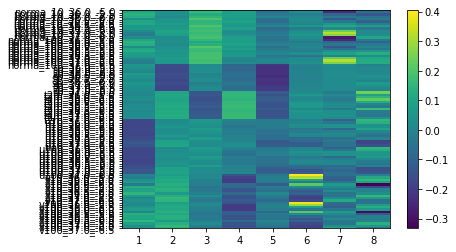

In [80]:
# Heatmap components
fig, ax = plt.subplots(nrows=1, ncols=1)
components = model_pca.components_
plt.imshow(components.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(x_train.columns)), x_train.columns)
plt.xticks(range(8), np.arange(model_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

In [81]:
model_pca.explained_variance_ratio_

array([0.29021031, 0.22187282, 0.15649911, 0.1047037 , 0.06600657,
       0.03027213, 0.02743054, 0.01909296])

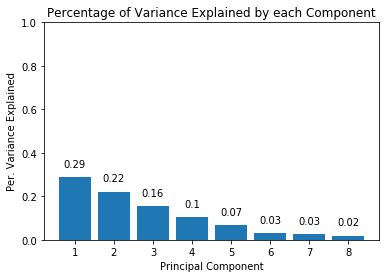

In [82]:
# graph of explained variance per each principal component
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.bar(
    x      = np.arange(model_pca.n_components_) + 1,
    height = model_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(8) + 1, model_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model_pca.n_components_) + 1)
ax.set_ylim(0, 1)
ax.set_title('Percentage of Variance Explained by each Component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Per. Variance Explained');

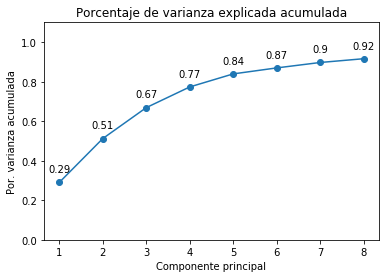

In [83]:
# graph of cumulative explained variance
prop_varianza_acum = model_pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    np.arange(8) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(8) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(model_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');
